На этом уроке мы с вами реализуем прямой проход сверточного слоя, обратный проход и расчет производных мы трогать не будем.

Вспомним как работает сверточный слой:

*   на вход подается массив изображений, еще он называется батчем

*   к каждому изображению по границам добавляются нули

*   по каждому изображению "скользит" каждый из фильтров сверточного слоя

Давайте начнем с разминки - реализуем функцию, добавляющую padding.

Пусть у нас есть батч input_images из двух изображений с тремя каналами (RGB). Размер изображений пусть будет 3*3. Вспомним, что вход сверточного слоя имеет следующую размерность:


*   размер батча
*   число каналов
*   высота
*   ширина

В рассматриваемом случае размерность входа (2, 3, 3, 3).

Если мы добавим вокруг каждого изображения отступ из одного нуля, то размер каждого изображений станет 3+2*1 = 5 пикселей в ширину и 5 в высоту соответственно (добавляем по одному нулю с каждой стороны изображения).

Напишите любую работающую реализацию.

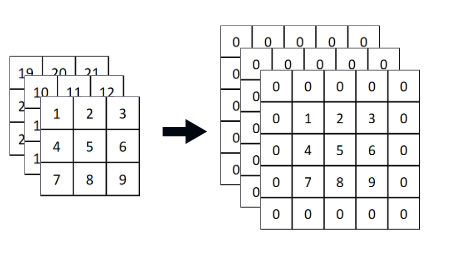

In [1]:
import torch
import numpy as np

# Создаем входной массив из двух изображений RGB 3*3
input_images = torch.tensor(
      [[[[0,  1,  2],
         [3,  4,  5],
         [6,  7,  8]],

        [[9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23],
         [24, 25, 26]]],


       [[[27, 28, 29],
         [30, 31, 32],
         [33, 34, 35]],

        [[36, 37, 38],
         [39, 40, 41],
         [42, 43, 44]],

        [[45, 46, 47],
         [48, 49, 50],
         [51, 52, 53]]]])


def get_padding2d(input_images):
    padded_images = torch.nn.functional.pad(input_images.float(), pad=(1,1,1,1))
    return padded_images


correct_padded_images = torch.tensor(
       [[[[0.,  0.,  0.,  0.,  0.],
          [0.,  0.,  1.,  2.,  0.],
          [0.,  3.,  4.,  5.,  0.],
          [0.,  6.,  7.,  8.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0.,  9., 10., 11.,  0.],
          [0., 12., 13., 14.,  0.],
          [0., 15., 16., 17.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0., 18., 19., 20.,  0.],
          [0., 21., 22., 23.,  0.],
          [0., 24., 25., 26.,  0.],
          [0.,  0.,  0.,  0.,  0.]]],


        [[[0.,  0.,  0.,  0.,  0.],
          [0., 27., 28., 29.,  0.],
          [0., 30., 31., 32.,  0.],
          [0., 33., 34., 35.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0., 36., 37., 38.,  0.],
          [0., 39., 40., 41.,  0.],
          [0., 42., 43., 44.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0., 45., 46., 47.,  0.],
          [0., 48., 49., 50.,  0.],
          [0., 51., 52., 53.,  0.],
          [0.,  0.,  0.,  0.,  0.]]]])

print(torch.allclose(get_padding2d(input_images), correct_padded_images))

True


На этом шаге детально рассмотрим из чего состоит сверточный слой.

Сверточный слой это массив фильтров.

Каждый фильтр имеет следующую размерность:

* число слоев во входном изображении (для RGB это 3)

* высота фильтра

* ширина фильтра




В ядре (кернеле) все фильтры имеют одинаковые размерность, поэтому ширину и высоту фильтров называют шириной и высотой ядра. Чаще всего ширина ядра равна высоте ядра, в таком случае их называют размером ядра (kernel_size).

 

Также слой имеет такие параметры:

* padding - на какое количество пикселей увеличивать входное изображение с каждой стороны.

* stride - на сколько пикселей смещается фильтр при вычислении свертки

 

Попробуйте самостоятельно вывести формулу размерности выхода сверточного слоя, зная параметры входа и ядра. 

Правильность формулы проверьте, сравнив ее с формулой из документации.

 

Чтобы убедиться в правильности вашей формулы, напишите функцию, принимающую на вход:

* входную размерность (число изображений в батче * число слоев в одном изображении * высота изображения * ширина изображения)

* количество фильтров

* размер фильтров (считаем, что высота совпадает с шириной)

* padding

* stride

Функция должна возвращать размерность выхода.

# Формула:



N - число изображений (input_matrix_shape[0])

$C_{in}$- количество входных каналов (для RGB С_in = 3)

$C_{out}$- количество выходных каналов или другими словами количество фильтров (out_channels) 

$H_{in}$ и $W_{in}$ - соответственно высота и ширина входной картинки (input_matrix_shape[2] и (input_matrix_shape[3])

$H_{out}$ и $W_{out}$ - соответственно высота и ширина выходного сверточного слоя 

Так как по условию все картинки и фильтры квадратные  (ширина = высота), то вышенаписанная формула примет следующий вид:

$H_{out} = {H_{in} - K+2P \over S}+1$



$W_{out} = {W_{in} - K+2P \over S}+1$


$H_{out} = W_{out}$

​
где 

K - размер ядра (kernel_size)

P - padding

S - stride

In [2]:
import numpy as np


def calc_out_shape(input_matrix_shape, out_channels, kernel_size, stride, padding):
    H = (input_matrix_shape[2] + 2 * padding - kernel_size ) // stride + 1# напишите тут код, вычисляющий выходную размерность
    out_shape = [2, out_channels, H, H]

    return out_shape

print(np.array_equal(
    calc_out_shape(input_matrix_shape=[2, 3, 10, 10],
                   out_channels=10,
                   kernel_size=3,
                   stride=1,
                   padding=0),
    [2, 10, 8, 8]))

# ... и ещё несколько подобных кейсов

True


# Код для проверки:

In [3]:
import torch
from abc import ABC, abstractmethod

# абстрактный класс для сверточного слоя
## Абстрактный слой в данном случае нужен для того, чтобы не перезадавать переменные
## Если мы делаем 2 разных класса, которые делают что-то похожее, то общую часть можно записать здесь и при создании нового класса наследовать этот
class ABCConv2d(ABC):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

    def set_kernel(self, kernel):
        self.kernel = kernel
## ниже указан декоратор @abstractmethod. Это значит, что при создании нового класса на основании этого функцию нужно будет переопределить иначе будет ошибка
    @abstractmethod
    def __call__(self, input_tensor):
        pass

# класс-обертка над torch.nn.Conv2d для унификации интерфейса
## Это класс который выполняет свёртку двумерного слоя согласно документации https://pytorch.org/docs/stable/nn.html#conv2d выполняется это следующим образом. Сам conv2d это класс. 
## Для начала нужно передать ему параметры. После этого вызвать как функцию с матрицей, которую нужно свернуть. 
## self.conv2d.weight.data = kernel - этой строкой кода мы меняем ядро с весами, сгенерированными по умолчанию,на наше, ручками сработанное ядро, т.е. мы добавили наше ядро в layer.
## weight и data:
# тип self.conv2d.weight - это <class 'torch.nn.parameter.Parameter'>
# тип self.conv2d.weight.data - это <class 'torch.Tensor'>
# self.conv2d.weight.data - это только тензор весов без дополнительных параметров, которые есть у self.conv2d.weight
class Conv2d(ABCConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
                                      stride, padding=0, bias=False)

    def set_kernel(self, kernel):
        self.conv2d.weight.data = kernel

    def __call__(self, input_tensor):
        return self.conv2d(input_tensor)
     


    # функция, создающая объект класса cls и возвращающая свертку от input_matrix
## Эта функия подготоавливает данные и вызывает нужный класс для свертки
## Сделано это для упрощения. 
## Обратите внимание самым первым параметром указывается класс, которым нужно свернуть матрицу   conv2d_layer_class

def create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_matrix):
    out_channels = kernel.shape[0]
    in_channels = kernel.shape[1]
    kernel_size = kernel.shape[2]

    layer = conv2d_layer_class(in_channels, out_channels, kernel_size, stride)
    layer.set_kernel(kernel)

    return layer(input_matrix)


# Функция, тестирующая класс conv2d_cls.
## Возвращает True, если свертка совпадает со сверткой с помощью torch.nn.Conv2d.
## Функция тестирует conv2d_layer_class. 

def test_conv2d_layer(conv2d_layer_class, batch_size=2,
                      input_height=4, input_width=4, stride=2):
    print('Вызвана функция test_conv2d_layer ей передан на тестирование класс ',conv2d_layer_class)
    
    kernel = torch.tensor(
                      [[[[0., 1, 0],
                         [1,  2, 1],
                         [0,  1, 0]],

                        [[1, 2, 1],
                         [0, 3, 3],
                         [0, 1, 10]],

                        [[10, 11, 12],
                         [13, 14, 15],
                         [16, 17, 18]]]])
    print('Kernel с помощю которого будет выполняться сворачивание \n', kernel)
    in_channels = kernel.shape[1]

## создается тензор размерности 6 таблиц 4*4 
## (то есть высота- 4, ширина -4) количество каналов - 3 (берется из размера kernel) и 2 батча 2*3=6
    input_tensor = torch.arange(0, batch_size * in_channels *
                                input_height * input_width,
                                out=torch.FloatTensor()).reshape(batch_size, in_channels, input_height, input_width)
    print('Матрица, которую надо будет свернуть \n', input_tensor)
 ## Здесь вызываются 2 фукнции, которые выполняют сворачивание
 ## Одной передается класс conv2d_layer_class другой Conv2d
 ## conv2d_layer_class это аргумент текущей функции 
 ## Эту функцию вызвали через print(test_conv2d_layer(Conv2d)) то есть по факту сравнивается Conv2d и Conv2d
 
    custom_conv2d_out = create_and_call_conv2d_layer(
        conv2d_layer_class, stride, kernel, input_tensor)
    print('Класс ',conv2d_layer_class,' выдает свернутую матрицу \n',custom_conv2d_out)

    conv2d_out = create_and_call_conv2d_layer(
        Conv2d, stride, kernel, input_tensor)
    print('Класс ',Conv2d,' выдает свернутую матрицу \n',conv2d_out)

    return torch.allclose(custom_conv2d_out, conv2d_out) and (custom_conv2d_out.shape == conv2d_out.shape)

print(test_conv2d_layer(Conv2d))

Вызвана функция test_conv2d_layer ей передан на тестирование класс  <class '__main__.Conv2d'>
Kernel с помощю которого будет выполняться сворачивание 
 tensor([[[[ 0.,  1.,  0.],
          [ 1.,  2.,  1.],
          [ 0.,  1.,  0.]],

         [[ 1.,  2.,  1.],
          [ 0.,  3.,  3.],
          [ 0.,  1., 10.]],

         [[10., 11., 12.],
          [13., 14., 15.],
          [16., 17., 18.]]]])
Матрица, которую надо будет свернуть 
 tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]],

         [[32., 33., 34., 35.],
          [36., 37., 38., 39.],
          [40., 41., 42., 43.],
          [44., 45., 46., 47.]]],


        [[[48., 49., 50., 51.],
          [52., 53., 54., 55.],
          [56., 57., 58., 59.],
          [60., 61., 62., 63.]],

         [[64., 65., 66., 67.],
     

Переиспользуем код с предыдущего шага для проверки своей реализации сверточного слоя.

Рассмотрим свертку батча из одного однослойного изображения 3 * 3 с ядром из одного фильтра 2 * 2, stride = 1, то есть, на выходе должна получиться одна матрица 2 * 2. Строго записанная размерность выхода равна (1 - изображений в батче, 1 - количество фильтров в ядре, 2 - высота матрицы выхода, 2 - ширина матрицы выхода).

Пусть W - веса ядра, X - вход, Y - выход.

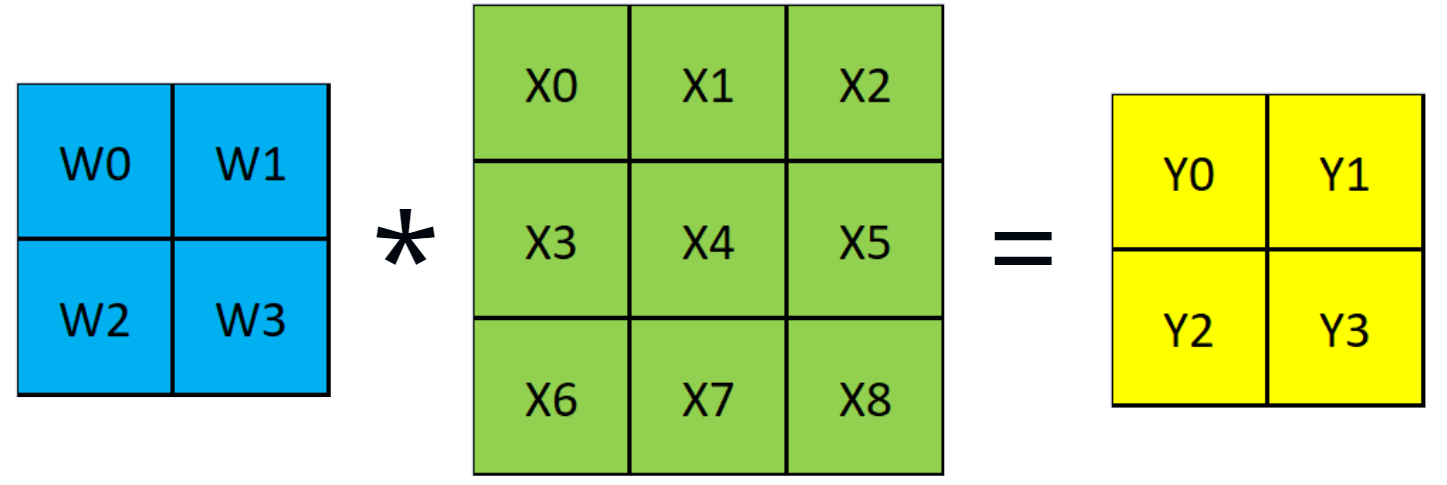

Вычислить выход можно в цикле:

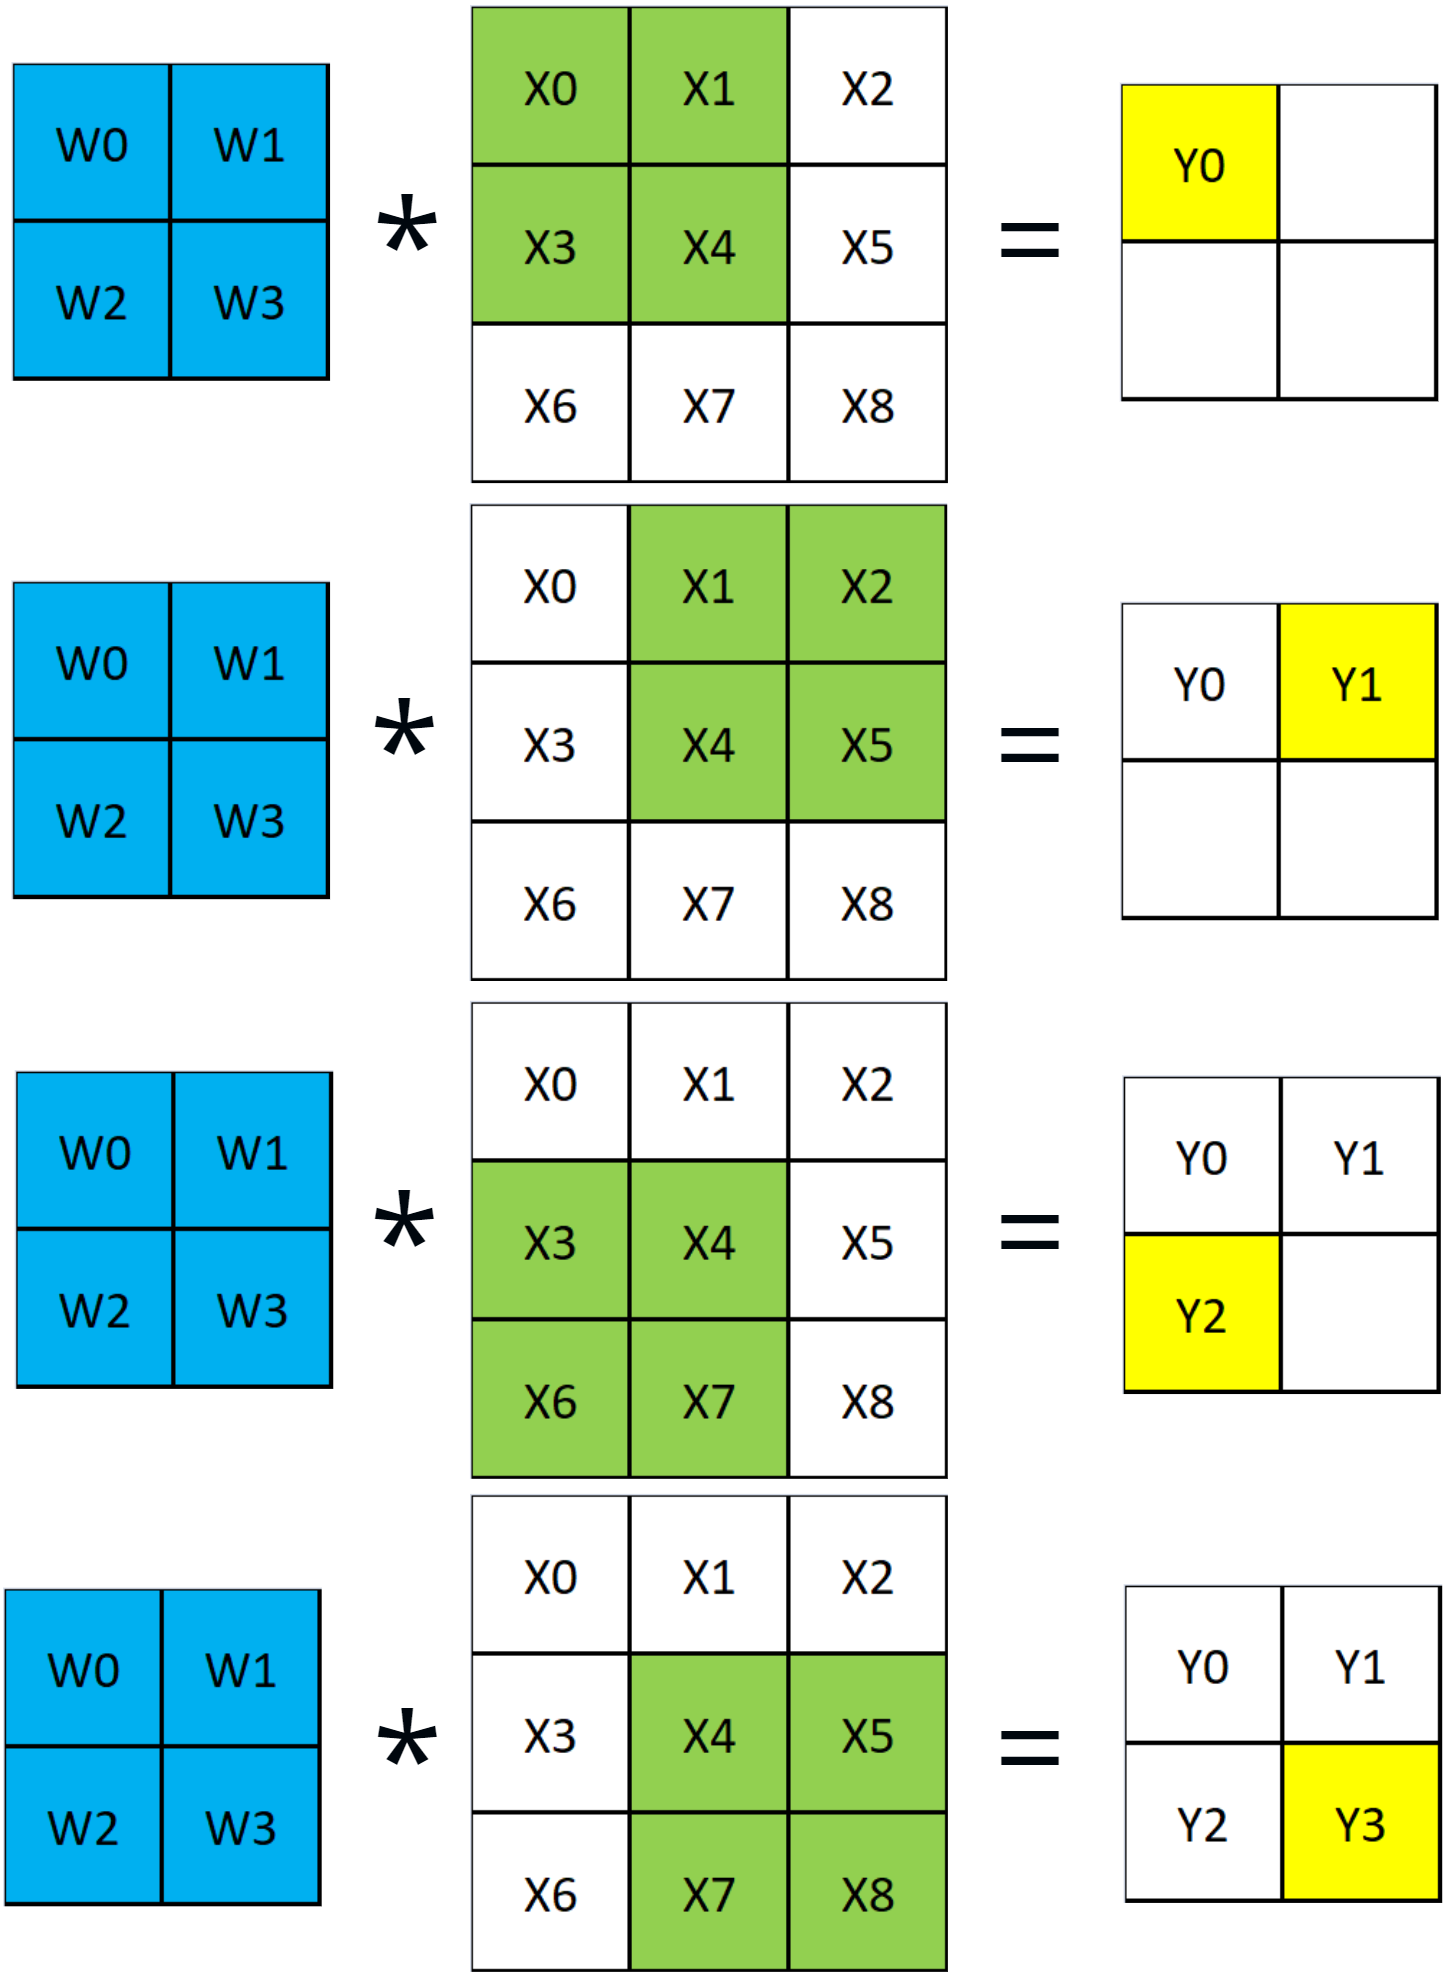

На каждой итерации цикла фильтр умножается попиксельно на часть изображения, а потом 4 получившиеся числа складываются - получается один пиксель выхода.

Требуемое количество итераций для данного случая - 4, так как может быть 2 положения ядра по горизонтали и 2 по вертикали, общее число итераций - произведение количеств положений, то есть в данном случае 2*2 = 4.

Давайте перейдем от простого случая к общему.

Если бы изображение было многослойным, например трехслойное - RGB, значит, фильтры в ядре тоже должны быть трехслойные. Каждый слой фильтра попиксельно умножается на соответствующий слой исходного изображения. То есть в данном случае после умножения получилось бы 4*3 = 12 произведений, результаты которых складываются, и получается значение выходного пикселя.

Если бы фильтров в ядре было больше одного, то добавился бы внешний цикл по фильтрам, внутри которого мы считаем свертку для каждого фильтра.

Если бы во входном батче было более 1 изображения, то добавился бы еще один внешний цикл по изображениям в батче.

Напоминание: во всех шагах этого урока мы считаем bias в сверточных слоях нулевым.

На этом шаге требуется реализовать сверточный слой через циклы.

Обратите внимание, что в коде рассматривается общий случай - батч на входе не обязательно состоит из одного изображения, в ядре несколько слоев.

In [4]:
import torch
from abc import ABC, abstractmethod


def calc_out_shape(input_matrix_shape, out_channels, kernel_size, stride, padding):
    batch_size, channels_count, input_height, input_width = input_matrix_shape
    output_height = (input_height + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    output_width = (input_width + 2 * padding - (kernel_size - 1) - 1) // stride + 1

    return batch_size, out_channels, output_height, output_width


class ABCConv2d(ABC):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

    def set_kernel(self, kernel):
        self.kernel = kernel

    @abstractmethod
    def __call__(self, input_tensor):
        pass


class Conv2d(ABCConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
                                      stride, padding=0, bias=False)

    def set_kernel(self, kernel):
        self.conv2d.weight.data = kernel

    def __call__(self, input_tensor):
        return self.conv2d(input_tensor)


def create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_matrix):
    out_channels = kernel.shape[0]
    in_channels = kernel.shape[1]
    kernel_size = kernel.shape[2]

    layer = conv2d_layer_class(in_channels, out_channels, kernel_size, stride)
    layer.set_kernel(kernel)

    return layer(input_matrix)


def test_conv2d_layer(conv2d_layer_class, batch_size=2,
                      input_height=4, input_width=4, stride=2):
    kernel = torch.tensor(
                      [[[[0., 1, 0],
                         [1,  2, 1],
                         [0,  1, 0]],

                        [[1, 2, 1],
                         [0, 3, 3],
                         [0, 1, 10]],

                        [[10, 11, 12],
                         [13, 14, 15],
                         [16, 17, 18]]]])

    in_channels = kernel.shape[1]

    input_tensor = torch.arange(0, batch_size * in_channels *
                                input_height * input_width,
                                out=torch.FloatTensor()) \
        .reshape(batch_size, in_channels, input_height, input_width)

    custom_conv2d_out = create_and_call_conv2d_layer(
        conv2d_layer_class, stride, kernel, input_tensor)
    conv2d_out = create_and_call_conv2d_layer(
        Conv2d, stride, kernel, input_tensor)
    return torch.allclose(custom_conv2d_out, conv2d_out) \
             and (custom_conv2d_out.shape == conv2d_out.shape)


# Сверточный слой через циклы.
class Conv2dLoop(ABCConv2d):
    def __call__(self, input_tensor):
      # Напишите в этом месте вычисление свертки с использованием циклов.
        output_tensor = torch.zeros(calc_out_shape(input_tensor.shape, self.out_channels, self.kernel_size, self.stride, 0)) 
        for batch_index in range(input_tensor.shape[0]):
          for filter_index in range(self.out_channels):
            for channel_index in range(input_tensor.shape[1]):
              for height_index in range(0, output_tensor.shape[2], self.stride):
                for width_index in range(0, output_tensor.shape[3], self.stride):
                  slice = input_tensor[batch_index, channel_index, height_index : height_index + self.kernel_size, width_index : width_index + self.kernel_size]
                  output_tensor[batch_index, filter_index, :, :] += (slice * self.kernel[filter_index, channel_index, :, :]).sum()
        print("Тензор кастомного класса:", output_tensor)
        return output_tensor

# Корректность реализации определится в сравнении со стандартным слоем из pytorch.
print(test_conv2d_layer(Conv2dLoop))

Тензор кастомного класса: tensor([[[[ 5252.]]],


        [[[12596.]]]])
True


Переиспользуем код с третьего шага для проверки своей реализации сверточного слоя.

Реализация через циклы очень неэффективна по производительности. Есть целых два способа сделать то же самое с помощью матричного умножения. 

На этом шаге будет реализация первым из них.

 

Рассмотрим свертку одного одноканального изображения размером 4*4 пикселя (значения пикселей обозначены через X).

Сворачивать будем с ядром из одного фильтра размером 3*3, веса обозначены через W.

Для простоты примем stride = 1.

Тогда выход Y будет иметь размерность 1 * 1 * 2 * 2 (в данном случае на входе одно изображение - это первая единица в размерности, в ядре один фильтр - это вторая единица в размерности выхода).

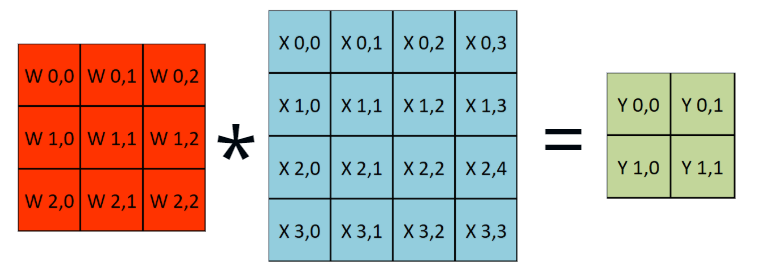




Оказывается, выход свертки можно получить умножением матриц, как показано ниже.






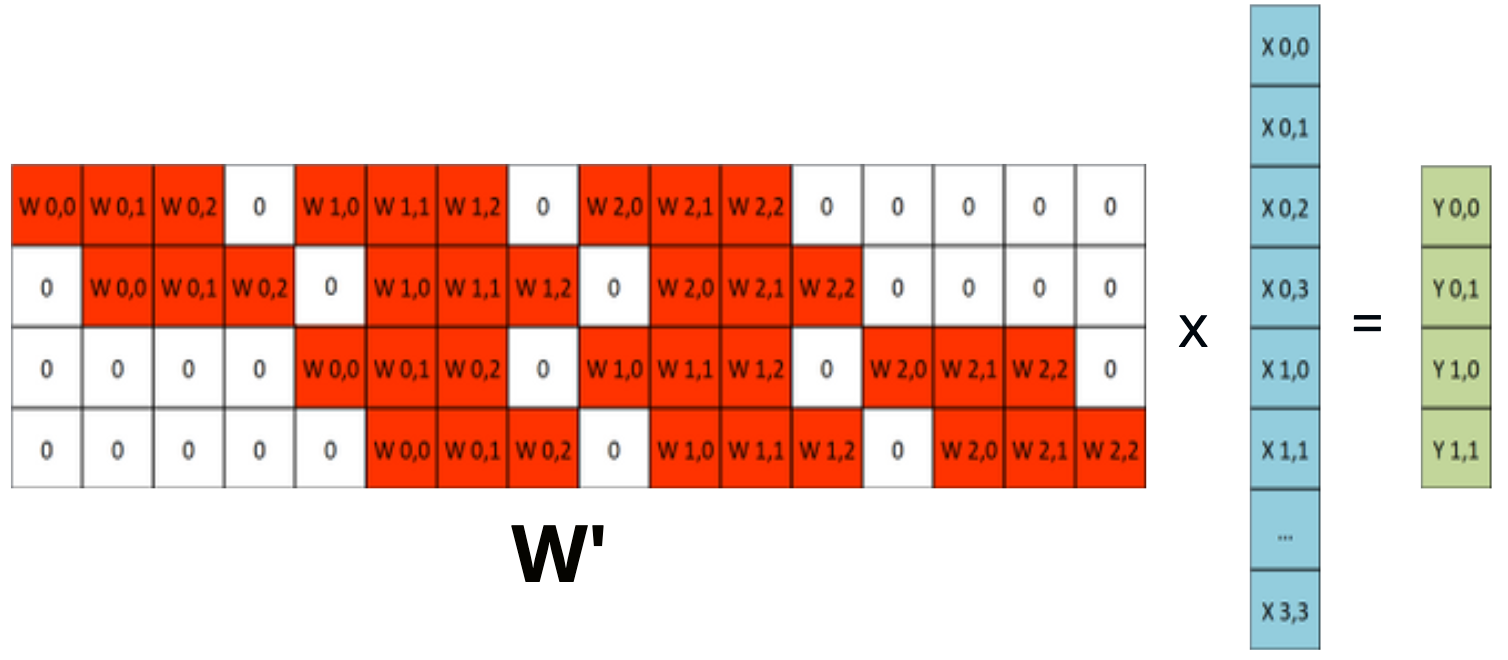

Рекомендуем убедиться в этом, перемножив матрицы на листочке.

Давайте перейдем от простого случая к общему:

Если фильтров в ядре больше одного. Заметим, что для каждого фильтра, матрица W’ будет умножаться на один и тот же вектор изображения. Значит, можно сконкатенировать матрицы фильтров ядра по вертикали и за одно умножение получить ответ для всех фильтров.
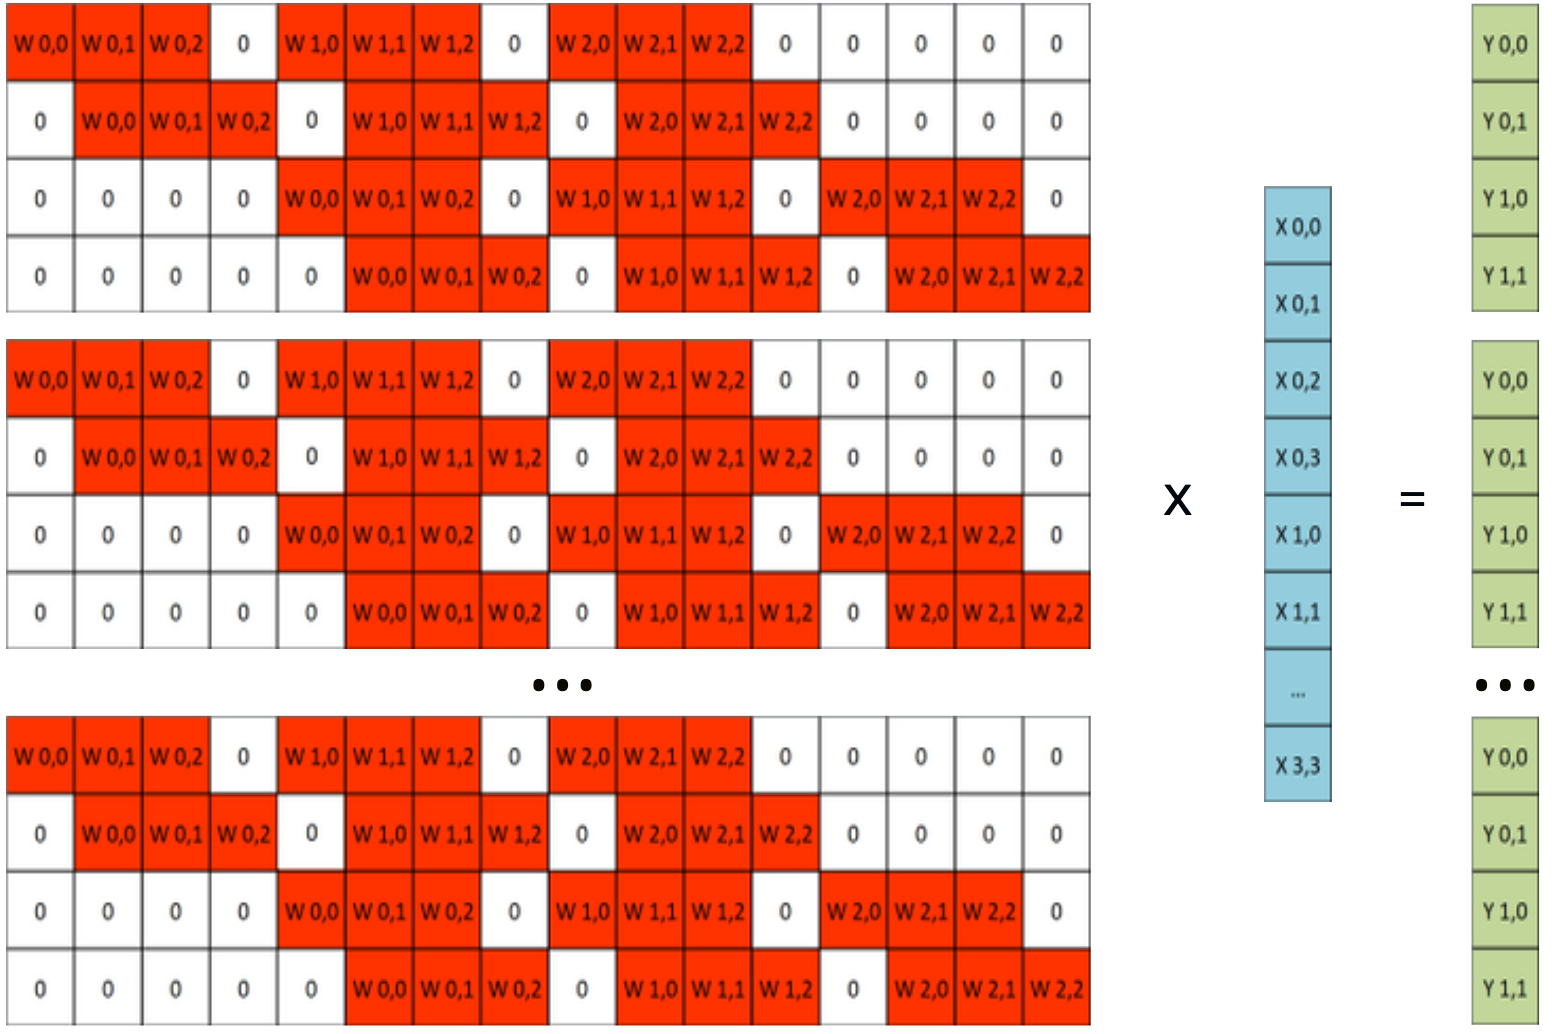


* Если на входе более одного изображения: заметим, что матрица W’ одинакова для всех изображений батча, то есть, можно каждое изображение вначале вытянуть в столбец, а затем эти столбцы для всех изображений батча сконкатенировать по горизонтали.

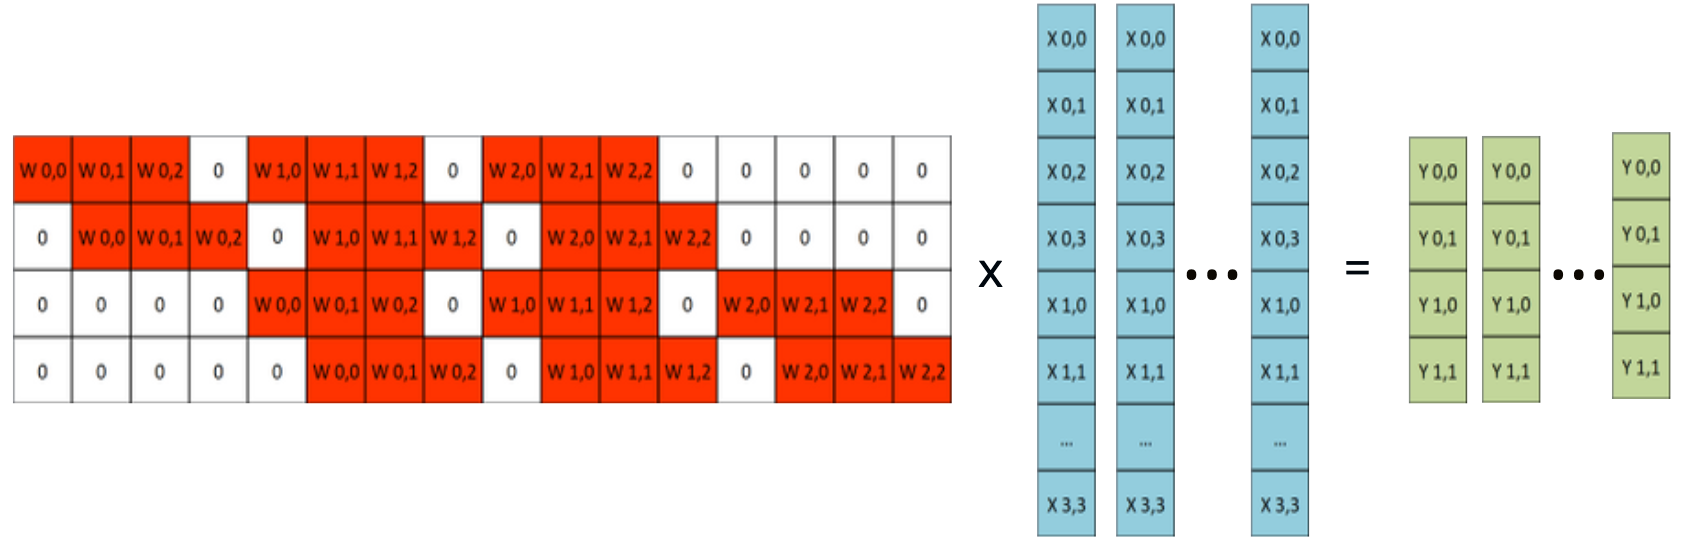

* Если в изображении больше одного слоя, вначале выполним преобразования входа и ядра для каждого слоя, а затем сконкатенируем: вектора разных слоев входа в один большой вектор, а матрицы ядра соответственно в одну длинную матрицу. И мы получим сложение от выходов по слоям в процессе перемножения матриц.

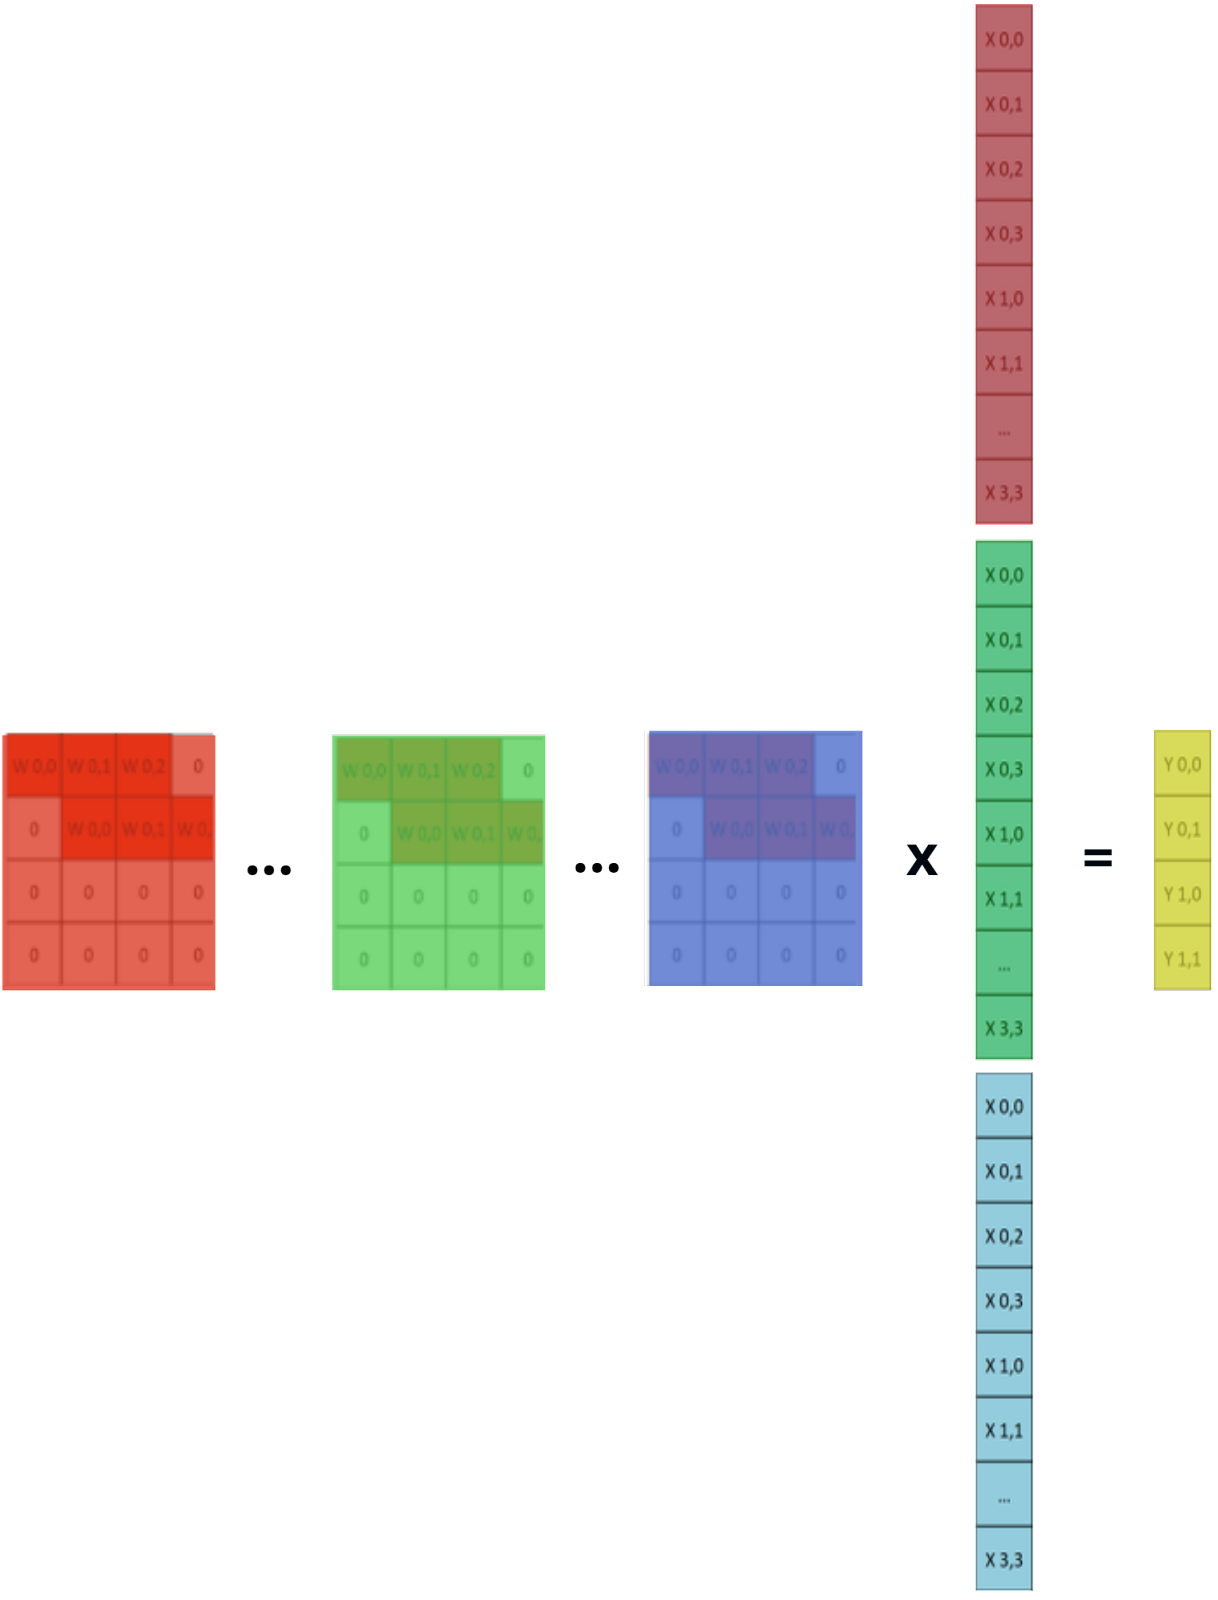

То есть даже в самом общем случае мы за одно умножение матриц можем получить ответ.

Но рассчитанный таким способом выход не совпадает по размерности с выходом стандартного слоя из PyTorch - нужно изменить размерность.

 

В коде уже реализовано:

* преобразование входного батча изображений

* умножение матрицы ядра на матрицу входа

* преобразование ответа

Напоминание: во всех шагах этого урока мы считаем bias в сверточных слоях нулевым.

Вам осталось реализовать преобразование ядра в описанный выше формат.

Обратите внимание, что в коде рассматривается общий случай - вход состоит из нескольких многослойных изображений, в ядре несколько слоев.

In [6]:
import torch
from abc import ABC, abstractmethod


def calc_out_shape(input_matrix_shape, out_channels, kernel_size, stride, padding):
    batch_size, channels_count, input_height, input_width = input_matrix_shape
    output_height = (input_height + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    output_width = (input_width + 2 * padding - (kernel_size - 1) - 1) // stride + 1

    return batch_size, out_channels, output_height, output_width


class ABCConv2d(ABC):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

    def set_kernel(self, kernel):
        self.kernel = kernel

    @abstractmethod
    def __call__(self, input_tensor):
        pass


class Conv2d(ABCConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
                                      stride, padding=0, bias=False)

    def set_kernel(self, kernel):
        self.conv2d.weight.data = kernel

    def __call__(self, input_tensor):
        return self.conv2d(input_tensor)


def create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_matrix):
    out_channels = kernel.shape[0]
    in_channels = kernel.shape[1]
    kernel_size = kernel.shape[2]

    layer = conv2d_layer_class(in_channels, out_channels, kernel_size, stride)
    layer.set_kernel(kernel)

    return layer(input_matrix)


def test_conv2d_layer(conv2d_layer_class, batch_size=2,
                      input_height=4, input_width=4, stride=2):
    kernel = torch.tensor(
                      [[[[0., 1, 0],
                         [1,  2, 1],
                         [0,  1, 0]],

                        [[1, 2, 1],
                         [0, 3, 3],
                         [0, 1, 10]],

                        [[10, 11, 12],
                         [13, 14, 15],
                         [16, 17, 18]]]])

    in_channels = kernel.shape[1]

    input_tensor = torch.arange(0, batch_size * in_channels *
                                input_height * input_width,
                                out=torch.FloatTensor()).reshape(batch_size, in_channels, input_height, input_width)

    custom_conv2d_out = create_and_call_conv2d_layer(
        conv2d_layer_class, stride, kernel, input_tensor)
    conv2d_out = create_and_call_conv2d_layer(
        Conv2d, stride, kernel, input_tensor)

    return torch.allclose(custom_conv2d_out, conv2d_out) and (custom_conv2d_out.shape == conv2d_out.shape)


class Conv2dMatrix(ABCConv2d):
    # Функция преобразование кернела в матрицу нужного вида.
## Общий случай
    def _unsqueeze_kernel(self, torch_input, output_height, output_width):
        _, in_channels, in_height, in_width = torch_input.shape
        kernel_unsqueezed_size = [self.out_channels, output_height, output_width, in_channels, in_height, in_width]
        kernel_unsqueezed = torch.zeros(kernel_unsqueezed_size, dtype=torch.float32)
        for i in range(output_height):
            for j in range(output_width):
                height_slice = slice(i*self.stride, i*self.stride+self.kernel_size)
                weight_slice = slice(j*self.stride, j*self.stride+self.kernel_size)
                kernel_unsqueezed[:, i, j, :, height_slice, weight_slice] = self.kernel.type(torch.float32)
        return kernel_unsqueezed.view(-1, in_channels*in_height*in_width)

## Конкретно этот случай
    # def _unsqueeze_kernel(self, torch_input, output_height, output_width):
    #   # Реализуйте функцию, возвращающую преобразованный кернел.
    #   # Матрица размера входной картинки, заполненная нулями
    #     zero_matrix = torch.zeros(4,4)
    #   # Ядро, дополненное нулями справа и снизу, чтобы подогнать под размер zero_matrix
    #     padded_kernel = torch.nn.functional.pad(self.kernel.float(), pad=(0,1,0,1))
    #   # Наложение padded_kernel на zero_matrix и разворачивание матрицы в строку.
    #     kernel_unsqueezed = (zero_matrix + padded_kernel).flatten()
    #   # В итоге получается строка длиной 48, так как stride=2
    #     return kernel_unsqueezed

    def __call__(self, torch_input):
        batch_size, out_channels, output_height, output_width = calc_out_shape(
                input_matrix_shape=torch_input.shape,
                out_channels=self.kernel.shape[0],
                kernel_size=self.kernel.shape[2],
                stride=self.stride,
                padding=0)

        kernel_unsqueezed = self._unsqueeze_kernel(torch_input, output_height, output_width)
        result = kernel_unsqueezed @ torch_input.view((batch_size, -1)).permute(1, 0)
        return result.view((batch_size, self.out_channels, output_height, output_width))

# Проверка происходит автоматически вызовом следующего кода
print(test_conv2d_layer(Conv2dMatrix))

True


На прошлом шаге W’ имеет много нулей. Это снижает эффективность метода.

На этом шаге будет реализация через матрицы другим, более эффективным способом.

Пусть в этот раз на входе батч из одного трехслойного (RGB) изображения размером 3 * 3.

Пусть ядро имеет 2 фильтра шириной и высотой 2 пикселя.

Тогда выход должен иметь размерность 1 * 2 * 2 * 2.

Пусть W - веса ядра, X - значения входной матрицы, Y - значения на выходе.

Для простоты слои изображения и слои фильтров ядра покрашены в цвета.

Обратите внимание, например, "синяя" X0 не обязано быть равно "красному" X0, аналогично и про значения в фильтрах ядра - разный цвет и одинаковые переменные могут иметь разные значения, такое обозначение выбрано, чтобы не загромождать рисунок сложными индексами.

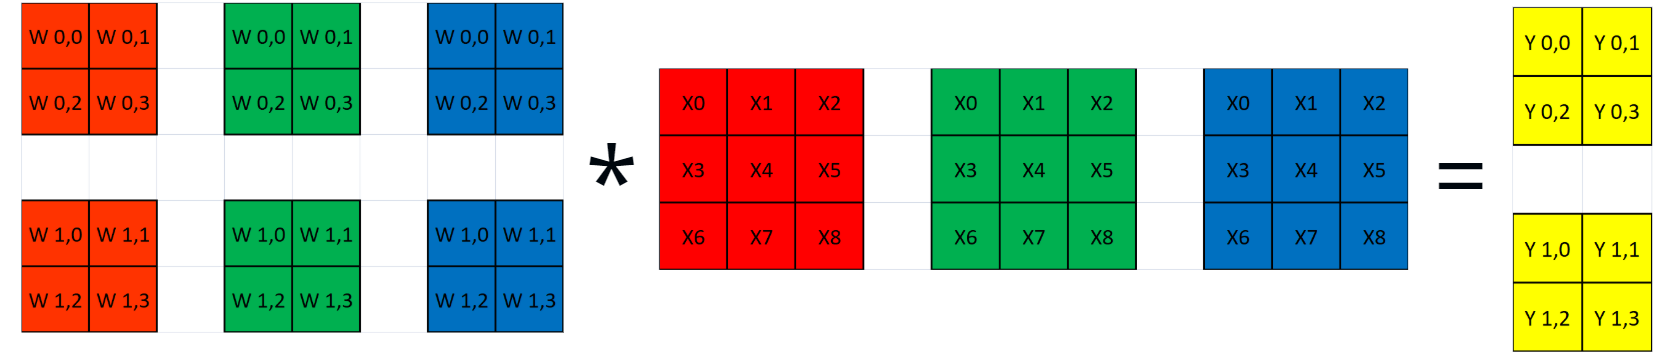

Если в первом матричном способе мы вытягивали изображения в столбцы, то теперь будем вытягивать фильтры кернела в строки.

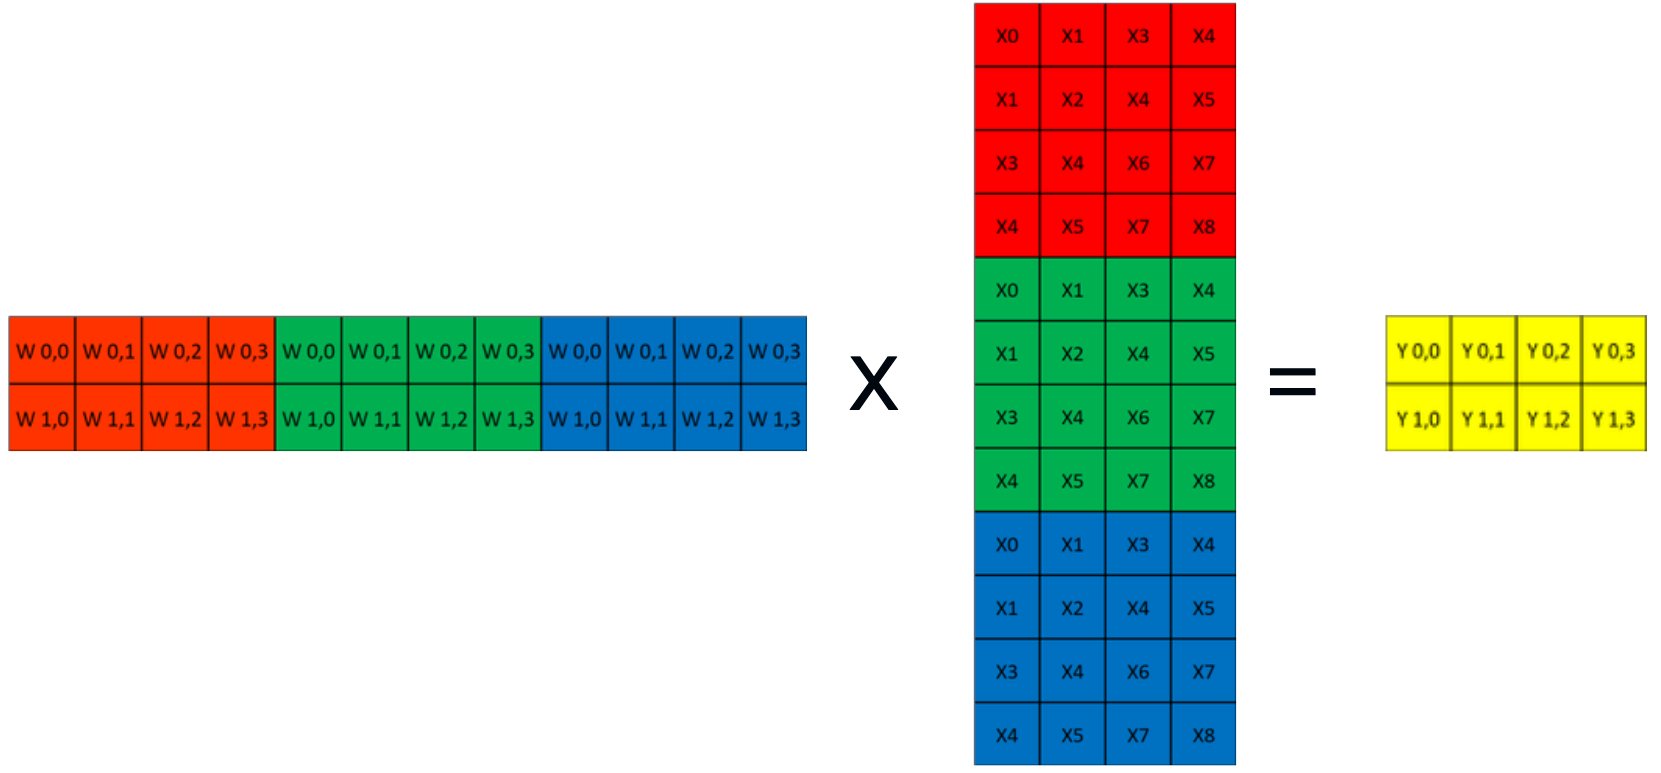

Рекомендуем проверить на листочке, что результат произведения таких матриц дает тот же результат, что и свертка.

Давайте перейдем от простого случая к общему:

Если изображений в батче больше одного: преобразования ядра от этого не меняется, а преобразованные матрицы входных изображений конкатенируются по горизонтали.

 

Но рассчитанный таким способом выход не совпадает по размерности с выходом стандартного слоя из PyTorch - нужно изменить размерность.

 

Функция умножения матриц уже реализована.

 

Напоминание: во всех шагах этого урока мы считаем bias в сверточных слоях нулевым.

Требуется написать функции преобразования ядра и входа.

In [12]:
import torch
from abc import ABC, abstractmethod


def calc_out_shape(input_matrix_shape, out_channels, kernel_size, stride, padding):
    batch_size, channels_count, input_height, input_width = input_matrix_shape
    output_height = (input_height + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    output_width = (input_width + 2 * padding - (kernel_size - 1) - 1) // stride + 1

    return batch_size, out_channels, output_height, output_width


class ABCConv2d(ABC):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

    def set_kernel(self, kernel):
        self.kernel = kernel

    @abstractmethod
    def __call__(self, input_tensor):
        pass


def create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_matrix):
    out_channels = kernel.shape[0]
    in_channels = kernel.shape[1]
    kernel_size = kernel.shape[2]

    layer = conv2d_layer_class(in_channels, out_channels, kernel_size, stride)
    layer.set_kernel(kernel)

    return layer(input_matrix)


class Conv2d(ABCConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
                                      stride, padding=0, bias=False)

    def set_kernel(self, kernel):
        self.conv2d.weight.data = kernel

    def __call__(self, input_tensor):
        return self.conv2d(input_tensor)


def test_conv2d_layer(conv2d_layer_class, batch_size=2,
                      input_height=4, input_width=4, stride=2):
    kernel = torch.tensor(
                      [[[[0., 1, 0],
                         [1,  2, 1],
                         [0,  1, 0]],

                        [[1, 2, 1],
                         [0, 3, 3],
                         [0, 1, 10]],

                        [[10, 11, 12],
                         [13, 14, 15],
                         [16, 17, 18]]]])

    in_channels = kernel.shape[1]

    input_tensor = torch.arange(0, batch_size * in_channels *
                                input_height * input_width,
                                out=torch.FloatTensor()) \
        .reshape(batch_size, in_channels, input_height, input_width)

    custom_conv2d_out = create_and_call_conv2d_layer(
        conv2d_layer_class, stride, kernel, input_tensor)
    conv2d_out = create_and_call_conv2d_layer(
        Conv2d, stride, kernel, input_tensor)

    return torch.allclose(custom_conv2d_out, conv2d_out) \
             and (custom_conv2d_out.shape == conv2d_out.shape)

    # def _unsqueeze_kernel(self, torch_input, output_height, output_width):
    #     _, in_channels, in_height, in_width = torch_input.shape
    #     kernel_unsqueezed_size = [self.out_channels, output_height, output_width, in_channels, in_height, in_width]
    #     kernel_unsqueezed = torch.zeros(kernel_unsqueezed_size, dtype=torch.float32)
    #     for i in range(output_height):
    #         for j in range(output_width):
    #             height_slice = slice(i*self.stride, i*self.stride+self.kernel_size)
    #             weight_slice = slice(j*self.stride, j*self.stride+self.kernel_size)
    #             kernel_unsqueezed[:, i, j, :, height_slice, weight_slice] = self.kernel.type(torch.float32)
    #     return kernel_unsqueezed.view(-1, in_channels*in_height*in_width)

class Conv2dMatrixV2(ABCConv2d):
    # Функция преобразования кернела в нужный формат.
    def _convert_kernel(self):
      # .view изменяет форму тензора, первый аргумент - количество строк, второй = -1 означает что не знаем сколько нужно столбцов, но строго знаем первый аргумент
        converted_kernel = self.kernel.view(self.kernel.shape[0], -1) # Реализуйте преобразование кернела.
        return converted_kernel

    # Функция преобразования входа в нужный формат.
    def _convert_input(self, torch_input, output_height, output_width):
        
        converted_input = torch.zeros(torch_input.shape[0],
                                      output_height*output_width,
                                      torch_input.shape[1],
                                      self.kernel_size,
                                      self.kernel_size)
        
        for row in range(0, output_height, self.stride):
            for column in range(0, output_width, self.stride):

                converted_input[:, row * output_width + column, :, :, :] = \
                torch_input[:, :, row : row + self.kernel_size, column : column + self.kernel_size]
        
        converted_input = converted_input.view(torch_input.shape[0] * output_height * output_width, -1)
        converted_input.t_()
        
        return converted_input

    def __call__(self, torch_input):
        batch_size, out_channels, output_height, output_width\
            = calc_out_shape(
                input_matrix_shape=torch_input.shape,
                out_channels=self.kernel.shape[0],
                kernel_size=self.kernel.shape[2],
                stride=self.stride,
                padding=0)

        converted_kernel = self._convert_kernel()
        converted_input = self._convert_input(torch_input, output_height, output_width)

        conv2d_out_alternative_matrix_v2 = converted_kernel @ converted_input
        return conv2d_out_alternative_matrix_v2.transpose(1,0).view(torch_input.shape[0],
                                                     self.out_channels, 
                                                     output_height,
                                                     output_width)

# Проверка происходит автоматически вызовом следующего кода
print(test_conv2d_layer(Conv2dMatrixV2))

True
